In [1]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference, SimpleInferer
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from monai.visualize import plot_2d_or_3d_image

In [2]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.7.0+43.g7b1b772a
Numpy version: 1.21.2
Pytorch version: 1.10.0a0+3fd9dcf
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: 7b1b772a4ad30c259696001a1a2380c52adffb65

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.2.0
Tensorboard version: 2.6.0
gdown version: 4.0.2
TorchVision version: 0.11.0a0
tqdm version: 4.62.1
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.3
einops version: 0.3.2
transformers version: 4.11.3
mlflow version: 1.20.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## create a temporary directory and 40 random image, mask pairs

In [3]:
tempdir = './tmp'
print(f"generating synthetic data to {tempdir} (this may take a while)")
for i in range(40):
    im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
    Image.fromarray((im * 255).astype("uint8")).save(os.path.join(tempdir, f"img{i:d}.png"))
    Image.fromarray((seg * 255).astype("uint8")).save(os.path.join(tempdir, f"seg{i:d}.png"))

generating synthetic data to ./tmp (this may take a while)


In [4]:
images = sorted(glob(os.path.join(tempdir, "img*.png")))
segs = sorted(glob(os.path.join(tempdir, "seg*.png")))

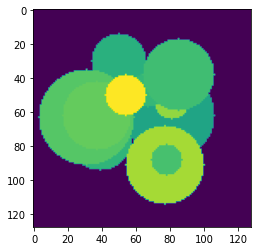

In [5]:
plt.imshow(im)

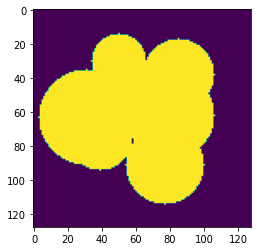

In [6]:
plt.imshow(seg)

## define transforms for image and segmentation

In [7]:
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)


In [8]:
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [9]:
val_imtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

## define array dataset, data loader

In [10]:
# define array dataset, data loader
check_ds = ArrayDataset(images, train_imtrans, segs, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


## create a training data loader

In [11]:
# create a training data loader
train_ds = ArrayDataset(images[:20], train_imtrans, segs[:20], train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

## create a validation data loader

In [12]:
# create a validation data loader
val_ds = ArrayDataset(images[-20:], val_imtrans, segs[-20:], val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

In [13]:
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [16]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
for epoch in range(30):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{10}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                #val_outputs = SimpleInferer(val_images, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)
            # plot the last model output as GIF image in TensorBoard with the corresponding image and label
            plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/10
1/5, train_loss: 0.2326
2/5, train_loss: 0.2371
3/5, train_loss: 0.2557
4/5, train_loss: 0.2502
5/5, train_loss: 0.2564
epoch 1 average loss: 0.2464
----------
epoch 2/10
1/5, train_loss: 0.2273
2/5, train_loss: 0.2417
3/5, train_loss: 0.2444
4/5, train_loss: 0.2533
5/5, train_loss: 0.2458
epoch 2 average loss: 0.2425
saved new best metric model
current epoch: 2 current mean dice: 0.9853 best mean dice: 0.9853 at epoch 2
----------
epoch 3/10
1/5, train_loss: 0.2176
2/5, train_loss: 0.2530
3/5, train_loss: 0.2359
4/5, train_loss: 0.2510
5/5, train_loss: 0.2434
epoch 3 average loss: 0.2402
----------
epoch 4/10
1/5, train_loss: 0.2551
2/5, train_loss: 0.2313
3/5, train_loss: 0.2476
4/5, train_loss: 0.2165
5/5, train_loss: 0.2205
epoch 4 average loss: 0.2342
saved new best metric model
current epoch: 4 current mean dice: 0.9853 best mean dice: 0.9853 at epoch 4
----------
epoch 5/10
1/5, train_loss: 0.2277
2/5, train_loss: 0.2270
3/5, train_loss: 0.2183
4/5, train_l

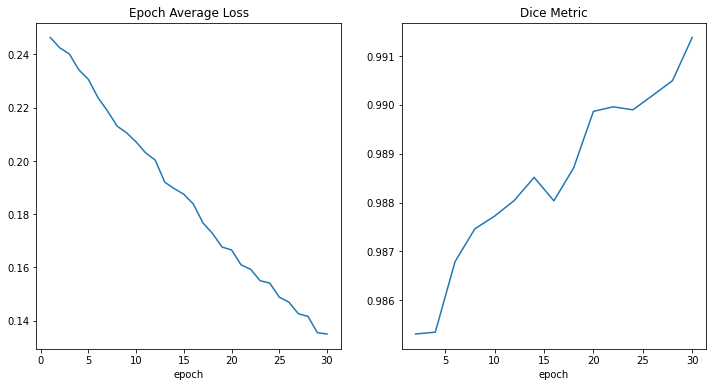

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Dice Metric")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [18]:
model

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [ ]:
with torch.no_grad():
    for batch in data.test_dataloader():
        inputs = batch['image'][tio.DATA].to(model.device)
        labels = model.net(inputs).argmax(dim=1, keepdim=True).cpu()
        for i in range(len(inputs)):
            break
        break   
batch_subjects = tio.utils.get_subjects_from_batch(batch)
tio.utils.add_images_from_batch(batch_subjects, labels, tio.LabelMap)

In [20]:
with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        roi_size = (96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
        #val_outputs = SimpleInferer(val_images, sw_batch_size, model)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        print(val_outputs)

[tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')]
[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')]
[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')]
[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0

In [33]:
val_outputs[0].shape

torch.Size([1, 128, 128])

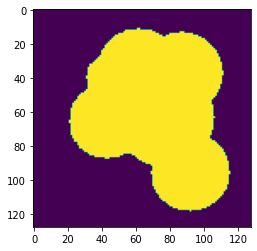

In [36]:
plt.imshow(val_outputs[0].cpu().permute(1,2,0))